Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Load Required librariese and  Import Skin Cancer Data

### Importing all the important libraries

In [28]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path("C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

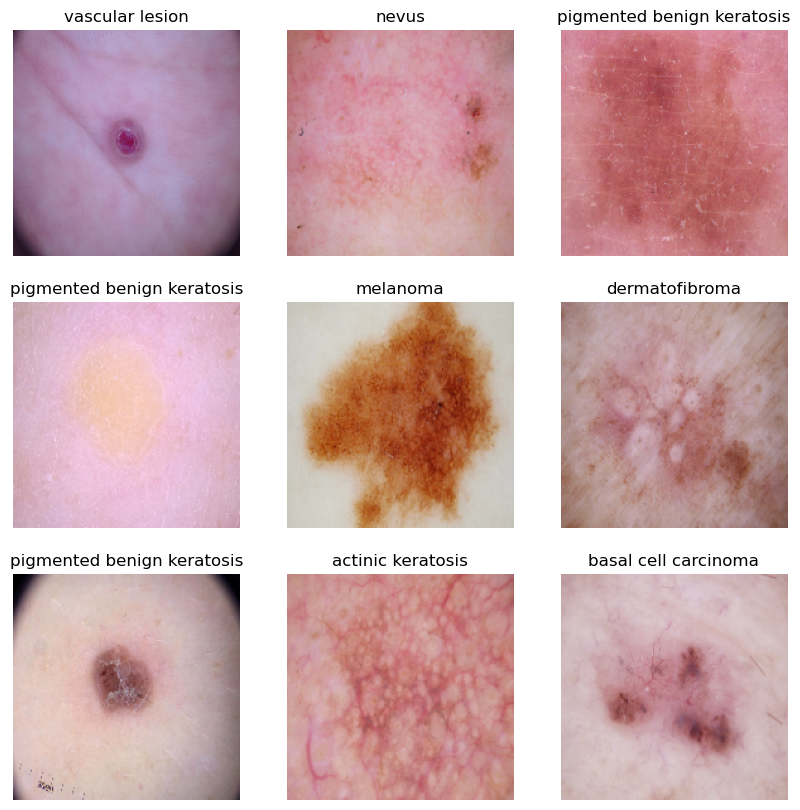

In [21]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training. 
- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [30]:
### Your code goes here

# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [37]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [41]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 55s 580ms/step - loss: 2.1282 - accuracy: 0.1987 - val_loss: 1.9551 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 45s 796ms/step - loss: 1.8533 - accuracy: 0.3119 - val_loss: 1.6775 - val_accuracy: 0.3736
Epoch 3/20
56/56 [==============================] - 31s 560ms/step - loss: 1.5690 - accuracy: 0.4470 - val_loss: 1.6179 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 48s 852ms/step - loss: 1.4141 - accuracy: 0.4967 - val_loss: 1.3997 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 49s 888ms/step - loss: 1.3002 - accuracy: 0.5402 - val_loss: 1.3735 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 38s 674ms/step - loss: 1.2472 - accuracy: 0.5625 - val_loss: 1.4705 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 39s 695ms/step - loss: 1.1438 - accuracy: 0.6032 - val_loss: 1.3844 - val_accuracy: 0.53

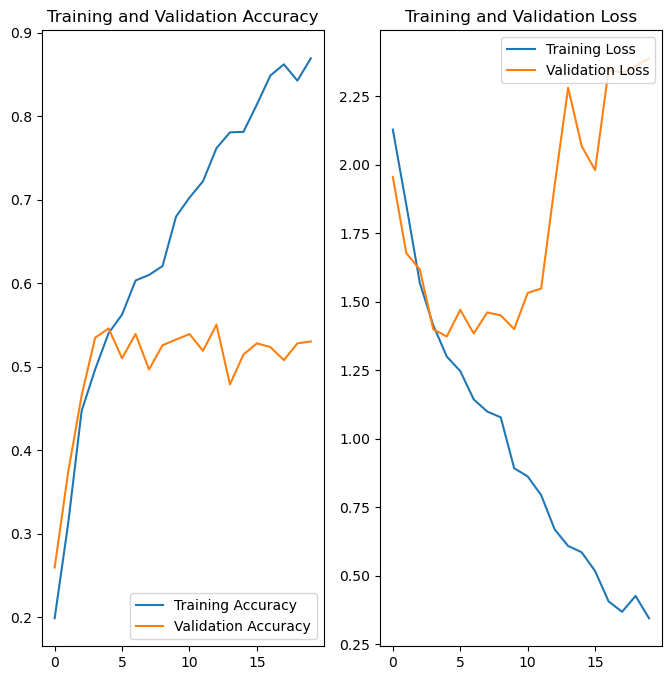

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

***Inferences:***

- The training accuracy of the model shows a steady increase of upto 88%, while validation accuracy remains consistently ~ 54%.

- A high training accuracy indicates the model has effectively captured the noise within the data. However,  the poor performance on validation data indicates a lack of generalizability.

- These inferences indicate the presence of overfitting. To mitigate this issue, augmentation techniques will be applied. Since the training data is limited, additional samples will be created by introducing slight modifications to the existing data (such as flipping images horizontally or vertically, applying small rotations, etc.), which will then be utilized for training the model.

In [52]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

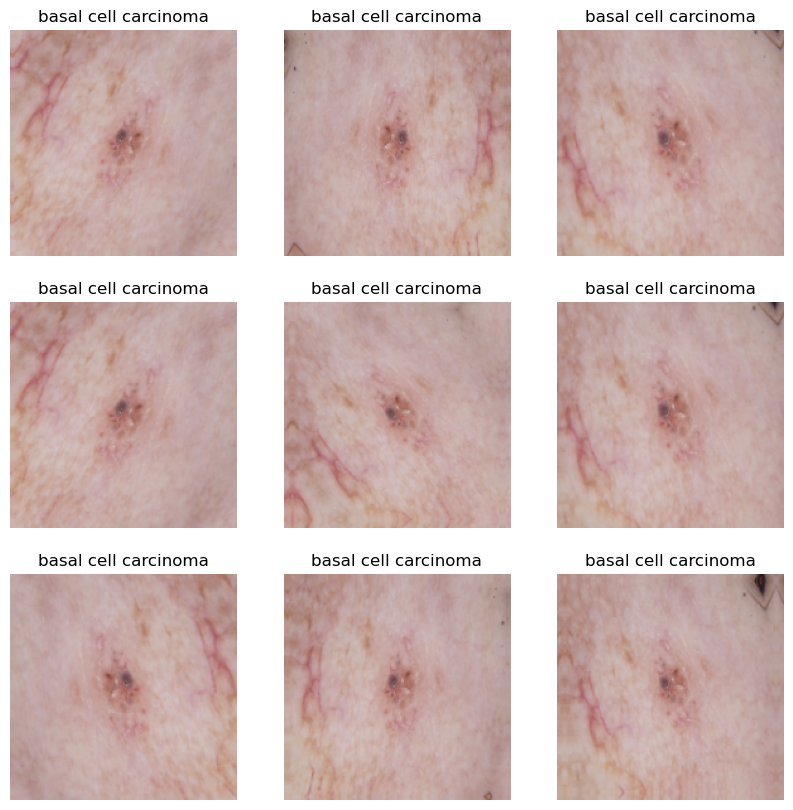

In [56]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Create the model, compile and train the model

In [59]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compiling the model

In [62]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [65]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 53s 784ms/step - loss: 2.0309 - accuracy: 0.2383 - val_loss: 1.7800 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 40s 716ms/step - loss: 1.6720 - accuracy: 0.4023 - val_loss: 1.5663 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 39s 701ms/step - loss: 1.5426 - accuracy: 0.4503 - val_loss: 1.4720 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 40s 714ms/step - loss: 1.4437 - accuracy: 0.4888 - val_loss: 1.3840 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 40s 708ms/step - loss: 1.3840 - accuracy: 0.5167 - val_loss: 1.4336 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 40s 710ms/step - loss: 1.2943 - accuracy: 0.5374 - val_loss: 1.3403 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 41s 735ms/step - loss: 1.3058 - accuracy: 0.5396 - val_loss: 1.3998 - val_accuracy: 0.4989

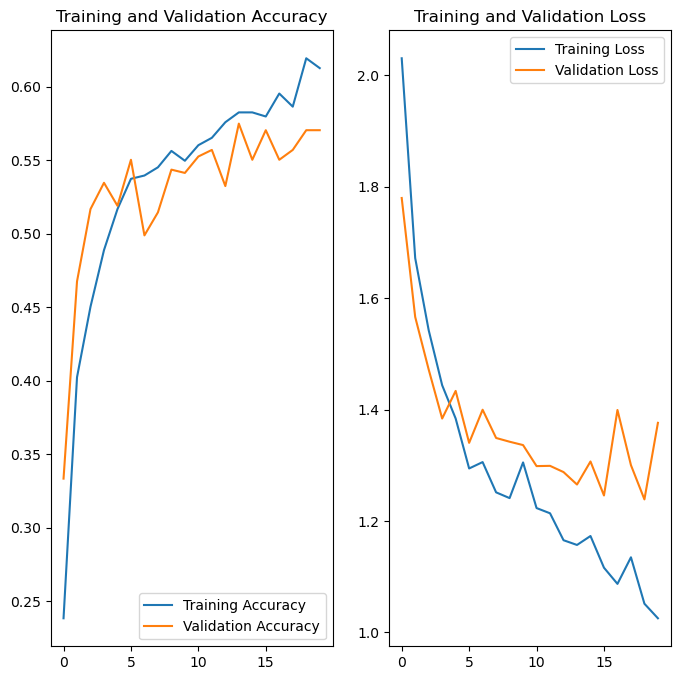

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Inferences:***

- Using augmented data has successfully mitigated overfitting.

- The training and validation accuracy of the model are now comparable.

- However, both the training and validation datasets exhibit poor performance, suggesting that the model is now underfitting.

#### Find the distribution of classes in the training dataset.
#### 
**Context:** Real-life datasets often exhibit class imbalance, where one class has a significantly higher number of samples compared to others. This imbalance can adversely impact the quality of the final model. Therefore, as a critical sanity check, it is essential to examine the class distribution within the dataset to identify and address any imbalances effectively.

In [72]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [74]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('C:\\Learning\\Technical\\DL(DeepLearning)\\MelanomaDetectingCaseStudy\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('C:\\Learning\\Technical\\DL(DeepLearning)\\MelanomaDetectingCaseStudy\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis'), ('C:\\Learning\\Technical\\DL(DeepLearning)\\MelanomaDetectingCaseStudy\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025825.jpg', 'actinic keratosis'), ('C:\\Learning\\Technical\\DL(DeepLearning)\\MelanomaDetectingCaseStudy\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025953.jpg', 'actinic keratosis'), ('C:\\Learning\\Technical\\DL(DeepLearning)\\MelanomaDetectingCaseStudy\\CNN_assignment\\Skin cancer ISIC The International

In [76]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis
1,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis
2,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis
3,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis
4,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis


In [78]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

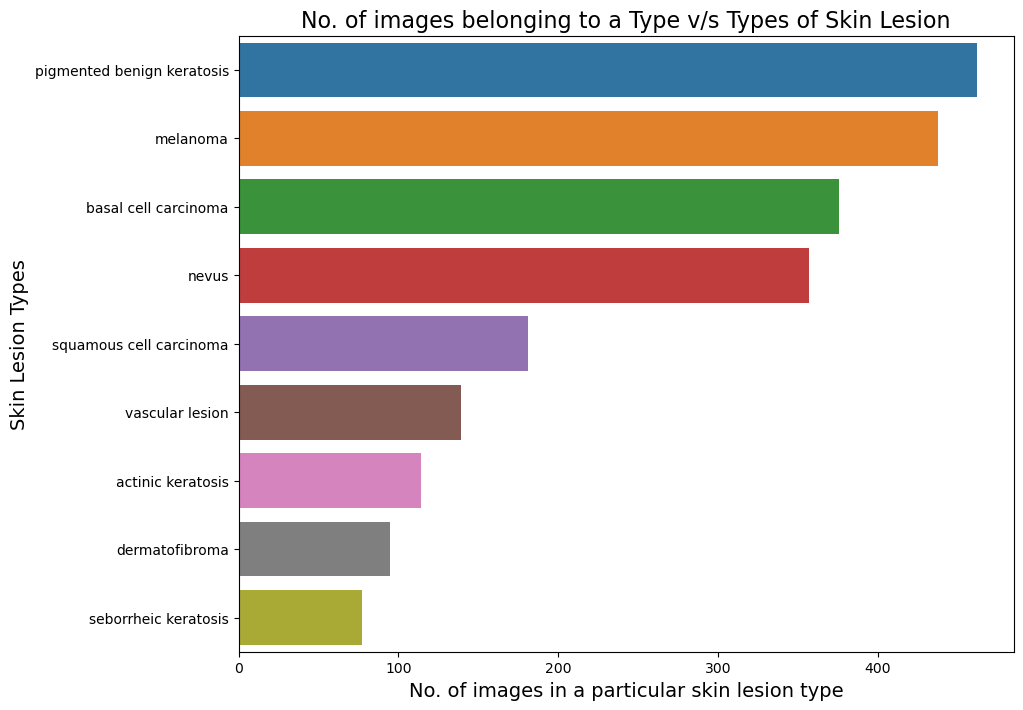

In [198]:
plt.figure(figsize=(10, 8))

# Sort the dataframe by count of each label
sorted_df = lesions_df['Label'].value_counts().reset_index()
sorted_df.columns = ['Label', 'Count']

# Plot the countplot using sorted labels
sns.countplot(
    y="Label", 
    data=lesions_df, 
    order=sorted_df['Label']  # Specify the order based on sorted counts
)

# Add titles and labels
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()


In [200]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

#### Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

***Inferences:***

- The training data clearly exhibits a class imbalance.  
-2. The class **"seborrheic keratosis"** has the fewest samples, making up roughly **3.44%** of the dataset.  -
3. **"Pigmented benign keratosis"** and **"melanoma"** dominate the dataset, accounting for approximately **20.63%** and **19.56%** of the samples, respectively.

Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.¶

In [93]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2405C9A01D0>: 100%|██████████| 500/500 [00:26<00:00, 18.75 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24027D15CD0>: 100%|██████████| 500/500 [00:24<00:00, 20.12 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x240A8CCF250>: 100%|██████████| 500/500 [00:21<00:00, 23.78 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x240172FE910>: 100%|██████████| 500/500 [03:30<00:00,  2.38 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x240A8477D90>: 100%|██████████| 500/500 [02:54<00:00,  2.87 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24027CB4910>: 100%|██████████| 500/500 [00:18<00:00, 26.74 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x240630C8DD0>: 100%|██████████| 500/500 [00:41<00:00, 11.96 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x240630D19D0>: 100%|██████████| 500/500 [00:17<00:00, 28.56 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Learning\Technical\DL(DeepLearning)\MelanomaDetectingCaseStudy\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x240A8D54950>: 100%|██████████| 500/500 [00:19<00:00, 25.93 Samples/s]                  


In [95]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [97]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['C:\\Learning\\Technical\\DL(DeepLearning)\\MelanomaDetectingCaseStudy\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_269be449-2427-4915-bd7a-6c35364a9f93.jpg',
 'C:\\Learning\\Technical\\DL(DeepLearning)\\MelanomaDetectingCaseStudy\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_450c685f-bcf6-4864-b882-bb467c441e71.jpg',
 'C:\\Learning\\Technical\\DL(DeepLearning)\\MelanomaDetectingCaseStudy\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_95be1172-d3c4-4f19-9277-6d6111db74c1.jpg',
 'C:\\Learning\\Technical\\DL(DeepLearning)\\MelanomaDetectingCaseStudy\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\out

In [99]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [105]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [109]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [111]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis
1,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis
2,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis
3,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis
4,C:\Learning\Technical\DL(DeepLearning)\Melanom...,actinic keratosis


In [113]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [115]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: proportion, dtype: float64

In [117]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [119]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [120]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [126]:
## your code goes here

model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [ ]:
#### Compile your model (Choose optimizer and loss function appropriately)

In [128]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#### Train your model

In [130]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 193s 1s/step - loss: 2.5835 - accuracy: 0.2743 - val_loss: 40.9851 - val_accuracy: 0.0831
Epoch 2/20
169/169 [==============================] - 182s 1s/step - loss: 1.5982 - accuracy: 0.3650 - val_loss: 19.5777 - val_accuracy: 0.0950
Epoch 3/20
169/169 [==============================] - 161s 948ms/step - loss: 1.4785 - accuracy: 0.4154 - val_loss: 2.7652 - val_accuracy: 0.2977
Epoch 4/20
169/169 [==============================] - 164s 963ms/step - loss: 1.4435 - accuracy: 0.4214 - val_loss: 1.4215 - val_accuracy: 0.4395
Epoch 5/20
169/169 [==============================] - 160s 941ms/step - loss: 1.3905 - accuracy: 0.4432 - val_loss: 1.5093 - val_accuracy: 0.4336
Epoch 6/20
169/169 [==============================] - 173s 1s/step - loss: 1.3692 - accuracy: 0.4540 - val_loss: 1.3997 - val_accuracy: 0.4543
Epoch 7/20
169/169 [==============================] - 181s 1s/step - loss: 1.3184 - accuracy: 0.4713 - val_loss: 1.7901 - val_accur

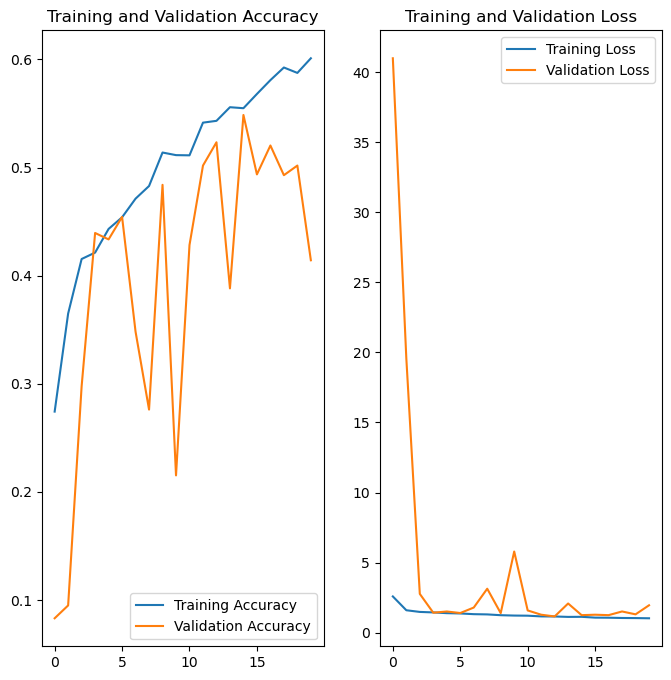

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Inferences:***

- Adding batch normalization to the model resulted in a modest improvement in both training and validation accuracy.
- Developing an alternative model without batch normalization is intended to explore potential accuracy enhancements.

#### Creating another model (without batch normalization)

In [134]:
# create the model
model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling the model

In [238]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [225]:
%%time
# train the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8681
Epoch 1: val_accuracy did not improve from 0.85746
169/169 [==============================] - 90s 524ms/step - loss: 0.3636 - accuracy: 0.8681 - val_loss: 0.6689 - val_accuracy: 0.8114
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.8973
Epoch 2: val_accuracy did not improve from 0.85746
169/169 [==============================] - 92s 539ms/step - loss: 0.2660 - accuracy: 0.8973 - val_loss: 0.7025 - val_accuracy: 0.8359
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9078
Epoch 3: val_accuracy improved from 0.85746 to 0.87305, saving model to model.keras
169/169 [==============================] - 93s 549ms/step - loss: 0.2497 - accuracy: 0.9078 - val_loss: 0.5870 - val_accuracy: 0.8731
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.8852
Epoch 4: val_accuracy did no

In [234]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

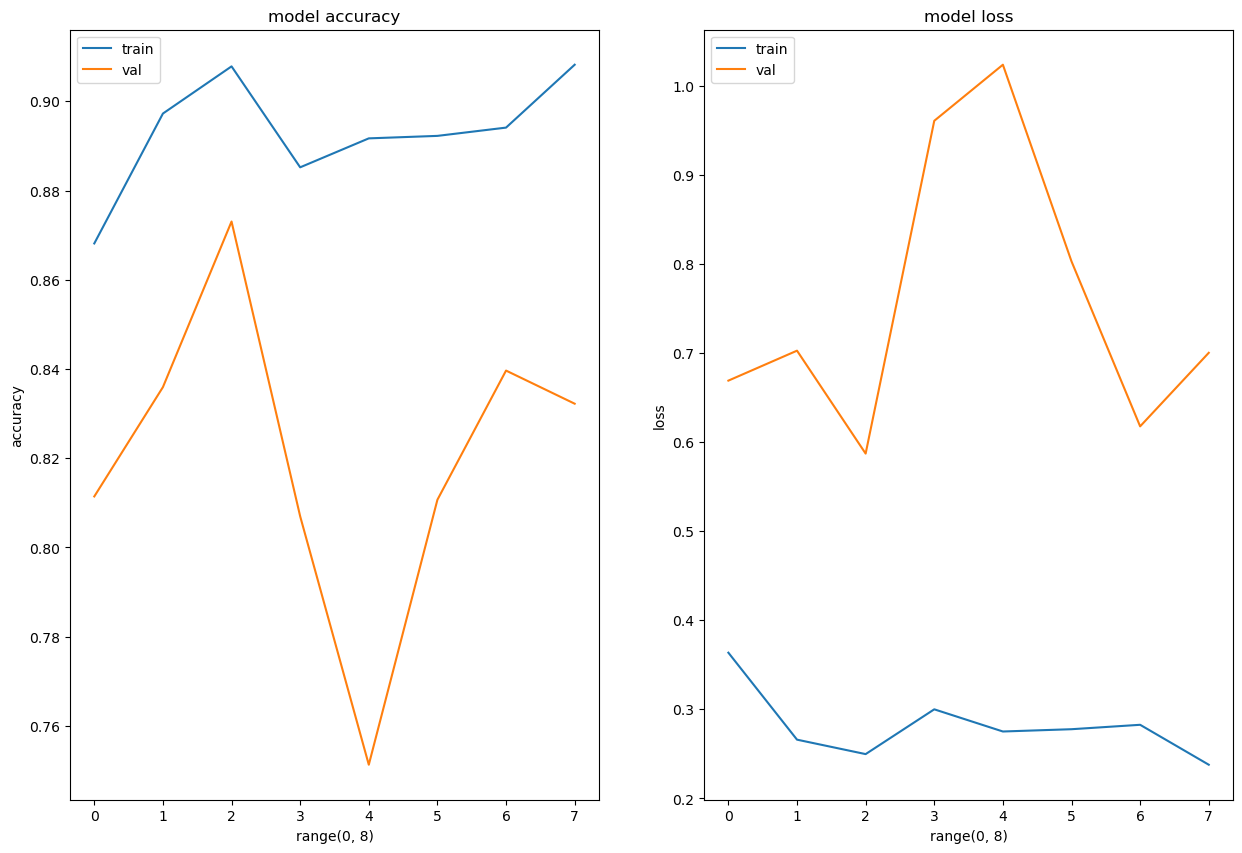

In [236]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


***Inferences:***
- The final model demonstrates a well-balanced performance, with no indications of underfitting or overfitting.  

- Incorporating class rebalancing has significantly improved the model's performance on both the training and validation datasets.  

- After setting to 30 epochs, the final model achieves an accuracy of 91% on the training set and approximately 83% on the validation set.  

- The minimal gap between training and validation accuracies highlights the strong generalization ability of the final CNN model.  

- Introducing batch normalization did not result in any improvement in training or validation accuracy.  

In [ ]:
### Model Evaluation

1/1 [==============================] - 0s 73ms/step
Actual Class: melanoma
Predicted Class: melanoma


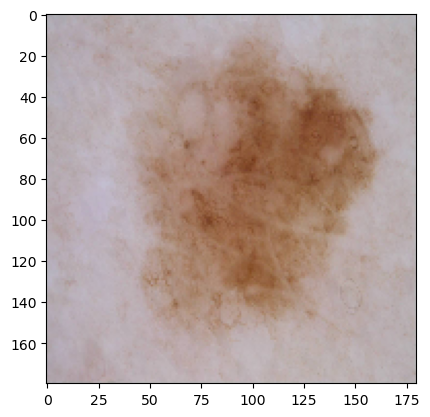

In [182]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[3], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[3] +'\n'+ "Predicted Class: " + predicted_class)